<a href="https://colab.research.google.com/github/sergioopereira/AI/blob/main/mod4_redes_neurais/Code/Model/cenario2/02_RedesNeurais_FeedForward.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy
import pandas as pd
from matplotlib import pyplot
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
import tensorflow
import keras
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
#source_file =  '../../../../PrevisaoVento/Data/process/cenario2/dados_cenario2.csv'
source_file =  'dados_cenario2.csv'
dataframe = pd.read_csv(source_file, delimiter=';', index_col=0, parse_dates=['Data'])

In [ ]:
dataframe.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8808 entries, 0 to 8807
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Longitude     8808 non-null   float64       
 1   Latitude      8808 non-null   float64       
 2   Data          8808 non-null   datetime64[ns]
 3   VentoC        8808 non-null   float64       
 4   Pressao       8808 non-null   float64       
 5   Temperatura   8808 non-null   float64       
 6   DirecaoVento  8808 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 550.5 KB


In [ ]:
df_day = dataframe[['Data', 'VentoC', 'Pressao','Temperatura']].groupby('Data').mean()
df_day.head(2)

,VentoC,Pressao,Temperatura
Data,,,
2017-01-01 00:00:00,9.815,882.334,22.192
2017-01-01 01:00:00,8.735,882.333,18.516


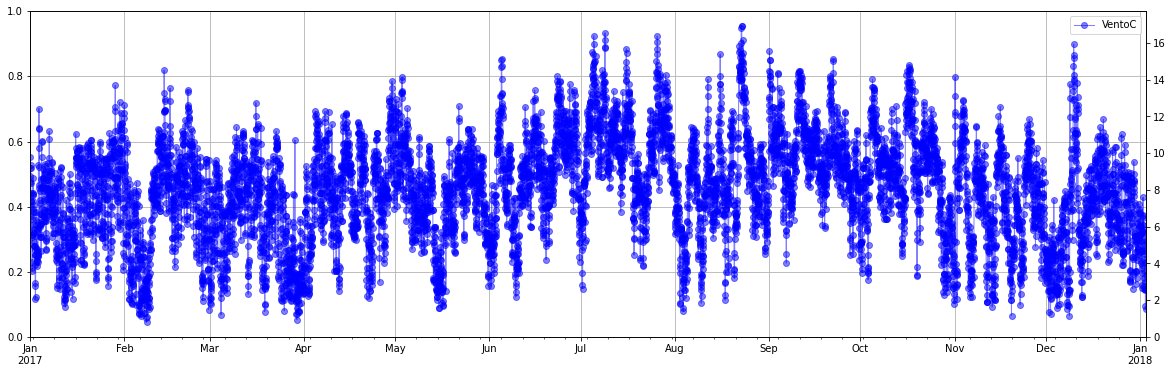

In [ ]:
fig = pyplot.figure(figsize=(20, 6))
ax = fig.add_subplot(111)
ax2 = ax.twinx()
_ = df_day.plot(y='VentoC', ax=ax2, lw=1, marker='o', color='blue', alpha=0.5)
#_ = df_day.plot(y='Temperatura', ax=ax, lw=1, marker='o', color='red', alpha=0.75)
_ = ax.grid()

In [ ]:
df_day['V_d1'] = df_day['VentoC'].shift(-1)
df_day['V_l1'] = df_day['VentoC'].shift(1)
df_day['V_l2'] = df_day['VentoC'].shift(2)
df_day['V_l3'] = df_day['VentoC'].shift(3)
df_day['V_l4'] = df_day['VentoC'].shift(4)
df_day['V_l5'] = df_day['VentoC'].shift(5)
df_day['V_l6'] = df_day['VentoC'].shift(6)
df_day['V_l7'] = df_day['VentoC'].shift(7)

#df_day['D_l1'] = df_day['DirecaoVento'].shift(1)
#df_day['D_l2'] = df_day['DirecaoVento'].shift(2)
#df_day['D_l3'] = df_day['DirecaoVento'].shift(3)
#df_day['D_l4'] = df_day['DirecaoVento'].shift(4)
#df_day['D_l5'] = df_day['DirecaoVento'].shift(5)
#df_day['D_l6'] = df_day['DirecaoVento'].shift(6)
#df_day['D_l7'] = df_day['DirecaoVento'].shift(7)

df_day['P_l1'] = df_day['Pressao'].shift(1)
df_day['P_l2'] = df_day['Pressao'].shift(2)
df_day['P_l3'] = df_day['Pressao'].shift(3)
df_day['P_l4'] = df_day['Pressao'].shift(4)
df_day['P_l5'] = df_day['Pressao'].shift(5)
df_day['P_l6'] = df_day['Pressao'].shift(6)
df_day['P_l7'] = df_day['Pressao'].shift(7)

df_day['T_l1'] = df_day['Temperatura'].shift(1)
df_day['T_l2'] = df_day['Temperatura'].shift(2)
df_day['T_l3'] = df_day['Temperatura'].shift(3)
df_day['T_l4'] = df_day['Temperatura'].shift(4)
df_day['T_l5'] = df_day['Temperatura'].shift(5)
df_day['T_l6'] = df_day['Temperatura'].shift(6)
df_day['T_l7'] = df_day['Temperatura'].shift(7)

complete_cases = ~df_day.isna().any(axis=1)
dfn = df_day[complete_cases]

In [ ]:
df_day.head(5)

,VentoC,Pressao,Temperatura,V_d1,V_l1,V_l2,V_l3,V_l4,V_l5,V_l6,V_l7,P_l1,P_l2,P_l3,P_l4,P_l5,P_l6,P_l7,T_l1,T_l2,T_l3,T_l4,T_l5,T_l6,T_l7
Data,,,,,,,,,,,,,,,,,,,,,,,,,
2017-01-01 00:00:00,9.815,882.334,22.192,8.735,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-01 01:00:00,8.735,882.333,18.516,8.454,9.815,NaN,NaN,NaN,NaN,NaN,NaN,882.334,NaN,NaN,NaN,NaN,NaN,NaN,22.192,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-01 02:00:00,8.454,882.000,17.633,9.178,8.735,9.815,NaN,NaN,NaN,NaN,NaN,882.333,882.334,NaN,NaN,NaN,NaN,NaN,18.516,22.192,NaN,NaN,NaN,NaN,NaN
2017-01-01 03:00:00,9.178,882.000,16.916,9.186,8.454,8.735,9.815,NaN,NaN,NaN,NaN,882.000,882.333,882.334,NaN,NaN,NaN,NaN,17.633,18.516,22.192,NaN,NaN,NaN,NaN
2017-01-01 04:00:00,9.186,882.666,16.483,9.361,9.178,8.454,8.735,9.815,NaN,NaN,NaN,882.000,882.000,882.333,882.334,NaN,NaN,NaN,16.916,17.633,18.516,22.192,NaN,NaN,NaN


In [20]:
# TRAINING
n_test_samples = 30
n_validation_samples = 30
random_seed = 32

# SET THE RANDOM SEED
numpy.random.seed(random_seed)
tensorflow.random.set_seed(random_seed)

x_cols = ['VentoC', 'V_l1','V_l2','V_l3','V_l4','V_l5','V_l6','V_l7',  'P_l1','P_l2','P_l3','P_l4','P_l5','P_l6','P_l7', 'T_l1','T_l2','T_l3','T_l4','T_l5','T_l6','T_l7']
y_cols = ['V_d1']

# SAMPLING
X_trn = dfn.iloc[:-(n_validation_samples + n_test_samples)][x_cols].to_numpy()
X_val = dfn.iloc[-(n_validation_samples + n_test_samples):-n_test_samples][x_cols].to_numpy()
X_tst = dfn[x_cols].to_numpy()
Y_trn = dfn.iloc[:-(n_validation_samples + n_test_samples)][y_cols].to_numpy()
Y_val = dfn.iloc[-(n_validation_samples + n_test_samples):-n_test_samples][y_cols].to_numpy()

# SCALING X
X_scaler = StandardScaler()
X_scaler = X_scaler.fit(X_trn)
X_trn_scaled = X_scaler.transform(X_trn)
X_val_scaled = X_scaler.transform(X_val)
X_tst_scaled = X_scaler.transform(X_tst)

# SCALING Y
Y_scaler = StandardScaler()
Y_scaler = Y_scaler.fit(Y_trn)
Y_trn_scaled = Y_scaler.transform(Y_trn)
Y_val_scaled = Y_scaler.transform(Y_val)

# DECLARE NET
max_neurons = 20
PATIENCE = 250
MAX_EPOCHS = 10*PATIENCE
LEARNING_RATE = 0.01
HIDDEN_ACTIVATION = 'relu'
MODEL_LOSS = 'val_loss'
MIN_IMPROVEMENT = 0.025

best_loss = 1000.0
best_val_loss = 1000.0
training_result_list = []
for n_neurons in numpy.arange(max_neurons) + 1:
    inputs = keras.Input(shape=(X_trn_scaled.shape[1]))
    hidden = keras.layers.Dense(n_neurons, activation=HIDDEN_ACTIVATION)(inputs)
    outputs = keras.layers.Dense(Y_trn_scaled.shape[1], activation='linear')(hidden)
    model_name = 'FORECAST_{}_{}'.format(HIDDEN_ACTIVATION, n_neurons)
    my_net = keras.Model(inputs=inputs, outputs=outputs, name=model_name)
    my_net.compile(optimizer=keras.optimizers.adam(learning_rate=LEARNING_RATE), loss='mse')
    #keras.optimizers.adam_v2
    #my_net.model.compile(loss='mse', optimizer='adam')
    es_callback = EarlyStopping(monitor='val_loss', mode='min', patience=PATIENCE, restore_best_weights=True)
    history = my_net.fit(X_trn_scaled, Y_trn_scaled, epochs=MAX_EPOCHS, validation_data=(X_val_scaled, Y_val_scaled), batch_size=X_trn_scaled.shape[0], callbacks=[es_callback], verbose=0)
    model_loss = history.history['loss'][-1]
    model_val_loss = history.history['val_loss'][-1]
    epochs = len(history.history['val_loss'])

    has_improved_val_loss = False
    loss_improvement = 1.0 - model_val_loss/best_val_loss

    if loss_improvement >= MIN_IMPROVEMENT:
        is_best_net = ((model_loss <= best_loss) & (model_val_loss < best_val_loss))

        if is_best_net:
                best_loss = model_loss
                best_val_loss = model_val_loss
                best_net = my_net
                best_history = history
                best_text = '***BEST NET!***'
                improvement_text = '{:.0f}% GAIN'.format(100.0*loss_improvement)
                best_name = model_name
                best_epochs = epochs
        else:
            best_text = ''
            improvement_text = ''
    else:
        print('EXTRA NEURON DIDNT IMPROVE NET {:.0f}% GAIN'.format(100.0*loss_improvement))
        break
    
    result_dict = {'model_name': model_name, 'epochs': epochs, 'model_loss': model_loss, 'model_val_loss': model_val_loss, 'best_net':is_best_net}
    
    
    training_result_list.append(result_dict)
    print('{} RESULTS > EPOCHS: {} LOSS: {:.3f} VAL_LOSS: {:.3f} {} {}'.format(model_name, epochs, model_loss, model_val_loss, best_text, improvement_text)) 

AttributeError: ignored

In [ ]:
Y_est_scaled = best_net.predict(X_tst_scaled)

Y_est = Y_scaler.inverse_transform(Y_est_scaled)


df_day.loc[complete_cases, ['Y_est']] = Y_est
df_day['residual'] = df_day['Y_est'] - df_day['V_d1']
df_day['rabs'] = df_day['residual'].abs()


model_r2_score = r2_score(df_day.loc[complete_cases, 'V_d1'].to_numpy(), df_day.loc[complete_cases, 'Y_est'].to_numpy())


In [ ]:
fig = pyplot.figure(figsize=(16, 9))
ax = fig.add_subplot(111)
_ = df_day.plot(y='V_d1', ax=ax, lw=1, marker='o', alpha=0.5)
_ = df_day.plot(y='Y_est', ax=ax, lw=1, marker='o', alpha=0.75, color='green')
_ = ax.grid()
_ = ax.set_title('MODELO {} R^2: {:.0f}%'.format(best_name, 100.0*model_r2_score), size=20)

In [ ]:
df_day.sort_values('rabs', ascending=True)

In [ ]:
#output_file = '../../../../PrevisaoVento/Data/process/cenario2/predicao_cenario2.csv'
output_file = 'predicao_cenario2.csv'
df_day.to_csv(output_file, sep=';', encoding='utf-8')

<h3>Instrução para exportação do modelo da rede neural</3>

from keras.models import load_model

** EXPOTACAO DO MODELO
model_file = '../../../../PrevisaoVento/Code/Model/modeloC1_previsao.pkl'
tensorflow.keras.models.save_model(best_net, model_file)


** IMPORTACAO DO MODELO
model = load_model(model_file)

** TESTE DO MODELO IMPORTADO
model.predict(numpy.array([[1, 10,11,13,  10,12,13 ,   90,91,90,  800,880,870  , 26,28,29]]))